In [12]:
import yaml
import numpy as np
from ngclib.graph_cfg import GraphCfg
from ngclib.models import NGCNode
from pprint import pprint
from torch import nn
from lightning_module_enhanced import LME
import torch as tr
import lovely_tensors
lovely_tensors.monkey_patch()

# NGC Ensembles


The easiest way to build an NGC is via the graph cfg which defines the nodes (types, names, hparams) and the edges (+types of edges)

NGC-Ensemble supports two type of edges: "SL" and "ENS" (as seen in the yaml file)

Code @ [ngclib/models/ngc_ensemble.py](../../ngclib/models/ngc_ensemble.py)

In [13]:
graph_cfg = GraphCfg(yaml.safe_load(open("ensembles.yaml", "r")))
print(graph_cfg)

[20230512 10:37:25-NGCLIB-DEBUG] Model type was not explictly given. Building from a default architecture: <class 'ngclib.models.ngc_ensemble.NGCEnsemble'> (graph_cfg.py:__init__:24)


[Graph Cfg]
 - NGC Type: <class 'ngclib.models.ngc_ensemble.NGCEnsemble'>
 - Node types: ['Example', 'Example', 'Example', 'Example', 'Example']
 - Node names: ['A', 'B', 'C', 'D', 'E']
 - Input nodes: ['A', 'B', 'C']
 - Output nodes: ['D', 'E']



We use `graph.cfg.build_model()` function, however this requires some parameters. A graph cfg is just a 'template' for building the model, no actual instances.

1) We need to first instantiate the nodes.
A node briefly represents the semantics of the task:
- hyperparams: num_classes, colormap
- metrics & possible loss_functions
- reading/saving npz to disk
- plot function for exporting pngs

2) Edge function
Each edge is a direct relationship between two nodes. Edges for NGC are neural networks. We need to define a callback that, when the edge is constructed from the given semantics (SL, ENS, hyper edge etc.), the proper neural network is also instantiated. Usually the same NN is copied across the entire graph (except differences at in_channels/out_channels), but this is just a particularity. We can define one callback for each edge.

3) Vote fn
The voting function (aggregation function). Called at each output node after the message-passing requested iterations have been finished. Semantics for each node can be passed via `partial` to this fn.

We are going to use a simple identical node (no complicated semantics, just in/out channels), a fully connected edge `nn.Linear(in, out)`, and the mean of the messages as aggregation function.

In [14]:
class Example(NGCNode):
    # a bunch of abstract methods required
    def save_to_disk(self, x: np.ndarray) -> np.ndarray:
        return x
    def load_from_disk(self, x: np.ndarray) -> np.ndarray:
        return x

nodes = [Example(name="A", dims=(1,)), Example(name="B", dims=(2,)), Example(name="C", dims=(3,)),
         Example(name="D", dims=(4,)), Example(name="E", dims=(5,))]
pprint(nodes)

edge_fn = nn.Linear
# For a given node of C channels: (V, C) => (C, )
vote_fn = lambda votes, sources: votes.mean(axis=1)

[A (state: None, num_messages: 0, dims: (1,)),
 B (state: None, num_messages: 0, dims: (2,)),
 C (state: None, num_messages: 0, dims: (3,)),
 D (state: None, num_messages: 0, dims: (4,)),
 E (state: None, num_messages: 0, dims: (5,))]


We can now build the NGC-Ensemble object

Layer (type:depth-idx)                   Param #
NGCEnsemble                              --
├─ModuleList: 1-1                        --
│    └─SingleLink: 2-1                   --
│    │    └─Linear: 3-1                  8
│    └─SingleLink: 2-2                   --
│    │    └─Linear: 3-2                  12
│    └─SingleLink: 2-3                   --
│    │    └─Linear: 3-3                  16
│    └─EnsembleEdge: 2-4                 --
│    │    └─Linear: 3-4                  25
Total params: 61
Trainable params: 61
Non-trainable params: 0


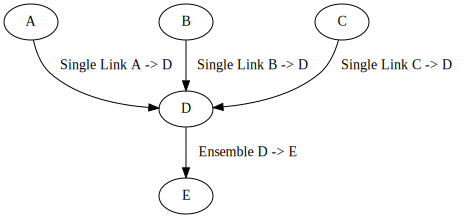

In [15]:
graph = graph_cfg.build_model(nodes, edge_fn, vote_fn)
print(LME(graph).summary)
display(graph.to_graphviz())

Message-passing through the graph. We are going to exemplify a simple message passing by creating a list of random tensors and seeing the results.


In [16]:
MB = 20
x = {
    "A": tr.randn(MB, 1),
    "B": tr.randn(MB, 2),
    "C": tr.randn(MB, 3)
}
y = graph(x)

pprint(x)
pprint(y)

{'A': tensor[20, 1] x∈[-1.733, 1.606] μ=-0.233 σ=0.824,
 'B': tensor[20, 2] n=40 x∈[-1.542, 2.382] μ=0.485 σ=1.150,
 'C': tensor[20, 3] n=60 x∈[-2.349, 2.795] μ=0.054 σ=1.088}
{'A': tensor[20, 1] x∈[-1.733, 1.606] μ=-0.233 σ=0.824,
 'B': tensor[20, 2] n=40 x∈[-1.542, 2.382] μ=0.485 σ=1.150,
 'C': tensor[20, 3] n=60 x∈[-2.349, 2.795] μ=0.054 σ=1.088,
 'D': tensor[20, 4] n=80 x∈[-1.181, 1.105] μ=-0.118 σ=0.450 grad MeanBackward1,
 'E': tensor[20, 5] n=100 x∈[-0.973, 0.906] μ=0.031 σ=0.384 grad MeanBackward1}


We observe an output at each node, be it input or output. 

We also observe that "D" and "E" outputs are the result of some averaging thanks to autograd.

We can further investigate the messages using the nodes' messages.

In [17]:
for node in graph.nodes:
    print(f"Node: {node.name}. N messages: {len(node.messages)}")

print("=== investigating D only ===")
D_msg = graph.name_to_node["D"].messages
pprint(D_msg)

D_stacked = tr.stack([x.content for x in D_msg])
print(f"D stacked: {D_stacked}")

assert tr.allclose(D_stacked.mean(dim=0), y["D"])

Node: A. N messages: 0
Node: B. N messages: 0
Node: C. N messages: 0
Node: E. N messages: 1
Node: D. N messages: 3
=== investigating D only ===
[M(s=Single Link A -> D|c=(20, 4)|t=0|pth=1),
 M(s=Single Link B -> D|c=(20, 4)|t=0|pth=1),
 M(s=Single Link C -> D|c=(20, 4)|t=0|pth=1)]
D stacked: tensor[3, 20, 4] n=240 x∈[-2.510, 2.416] μ=-0.118 σ=0.810 grad StackBackward0


# HyperEdges

Code @ [ngclib/models/ngc_hyperedges.py](../../ngclib/models/ngc_hyperedges.py)

Semantics are slightly more complicated to model using message passing. See here how they were derived: [link](https://docs.google.com/document/d/1FEnICEXXVlkqP0t4FFaWz9xGUSQhjn-Ik3nLtWKqGVw/edit#heading=h.ipdhucvyxtgv)

In [18]:
graph_cfg_2 = GraphCfg(yaml.safe_load(open("hypergraph.yaml", "r")))
print(graph_cfg_2)

[20230512 10:37:25-NGCLIB-DEBUG] Model type was not explictly given. Building from a default architecture: <class 'ngclib.models.ngc_hyperedges.NGCHyperEdges'> (graph_cfg.py:__init__:24)


[Graph Cfg]
 - NGC Type: <class 'ngclib.models.ngc_hyperedges.NGCHyperEdges'>
 - Node types: ['Example', 'Example', 'Example', 'Example', 'Example']
 - Node names: ['A', 'B', 'C', 'D', 'E']
 - Input nodes: ['A', 'B', 'C']
 - Output nodes: ['D', 'E']



[20230512 10:37:25-NWGRAPH-WARNING] You have identical edges. Removing duplicates 16 => 10 (graph.py:_remove_identical_edges:162)


Layer (type:depth-idx)                   Param #
NGCHyperEdges                            --
├─ModuleList: 1-1                        --
│    └─IdentityEdge: 2-1                 --
│    │    └─Identity: 3-1                --
│    └─IdentityEdge: 2-2                 --
│    │    └─Identity: 3-2                --
│    └─HyperEdge: 2-3                    --
│    │    └─Linear: 3-3                  28
│    └─HyperEdge: 2-4                    --
│    │    └─Linear: 3-4                  80
│    └─IdentityEdge: 2-5                 --
│    │    └─Identity: 3-5                --
│    └─IdentityEdge: 2-6                 --
│    │    └─Identity: 3-6                --
│    └─IdentityEdge: 2-7                 --
│    │    └─Identity: 3-7                --
│    └─HyperEdge: 2-8                    --
│    │    └─Linear: 3-8                  35
│    └─HyperEdge: 2-9                    --
│    │    └─Linear: 3-9                  64
│    └─IdentityEdge: 2-10                --
│    │    └─Identity: 3-10 

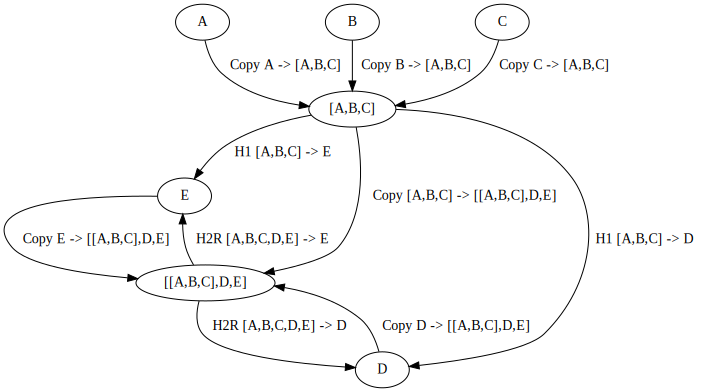

In [19]:
graph_2 = graph_cfg_2.build_model(nodes, edge_fn, vote_fn)
print(LME(graph_2).summary)
display(graph_2.to_graphviz())

Same way of running tesnors through the graph:

In [20]:
y2 = graph_2(x)
pprint(x)
pprint(y2)

for node in graph_2.nodes:
    print(f"Node: {node.name}. N messages: {len(node.messages)}")

{'A': tensor[20, 1] x∈[-1.733, 1.606] μ=-0.233 σ=0.824,
 'B': tensor[20, 2] n=40 x∈[-1.542, 2.382] μ=0.485 σ=1.150,
 'C': tensor[20, 3] n=60 x∈[-2.349, 2.795] μ=0.054 σ=1.088}
{'A': tensor[20, 1] x∈[-1.733, 1.606] μ=-0.233 σ=0.824,
 'B': tensor[20, 2] n=40 x∈[-1.542, 2.382] μ=0.485 σ=1.150,
 'C': tensor[20, 3] n=60 x∈[-2.349, 2.795] μ=0.054 σ=1.088,
 'D': tensor[20, 4] n=80 x∈[-1.387, 1.610] μ=0.159 σ=0.584 grad MeanBackward1,
 'E': tensor[20, 5] n=100 x∈[-1.412, 0.829] μ=-0.104 σ=0.438 grad MeanBackward1,
 '[A,B,C]': tensor[20, 6] n=120 x∈[-2.349, 2.795] μ=0.150 σ=1.093,
 '[[A,B,C],D,E]': tensor[20, 15] n=300 x∈[-2.349, 2.795] μ=0.040 σ=0.894 grad CatBackward0}
Node: A. N messages: 0
Node: B. N messages: 0
Node: C. N messages: 0
Node: [A,B,C]. N messages: 3
Node: E. N messages: 2
Node: [[A,B,C],D,E]. N messages: 3
Node: D. N messages: 2
